#### Project: Incremental Capstone Session 11
#### Author: Davis Byrd
#### Date: 4/27/2025

### Task: Build a CNN-LSTM hybrid model to classify the customer product reviews into good or bad.

### Import necessary modules

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed
np.random.seed(32)

# Scikit-learn
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE

# TensorFlow and Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout, 
    LSTM, Conv1D, MaxPooling1D, 
    GlobalAveragePooling1D, Embedding
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Sequential

from tensorflow.keras.utils import to_categorical


#%matplotlib inline

### Load dataset

In [3]:
df = pd.read_csv('GrammarandProductReviews.csv')

In [4]:
df.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.03E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.03E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427


##### We will only consider the text of the reviews and the ratings.
##### We are going to make an approximation in order to predict from the text and the satisfaction level of the customer.

(array([ 249.,    0.,  145.,    0.,    0.,  453.,    0., 2856.,    0.,
        6298.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

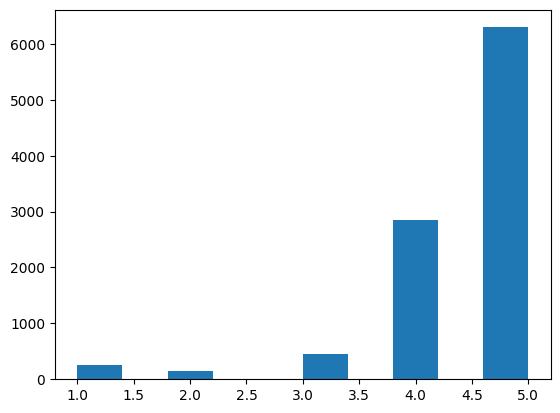

In [5]:
plt.hist(df['reviews.rating'])

#### Observation
- ##### The histogram plot shows the distribution/count of each ratings in the dataset

### Create a feature named target by considering that if a customer is pleased by the product, the rating is higher than 3. Any rating below 4 shows that the customer doesn’t like the product. Use column reviews.rating to create feature target (Hint: df['target'] = df['reviews.rating'] < 4 )

In [6]:
df['target'] = df['reviews.rating'] < 4

In [7]:
df['target'].value_counts()

target
False    9154
True      847
Name: count, dtype: int64

##### Those reviews > 4 will be False and those reviews < 4 will be True

(array([9154.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         847.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

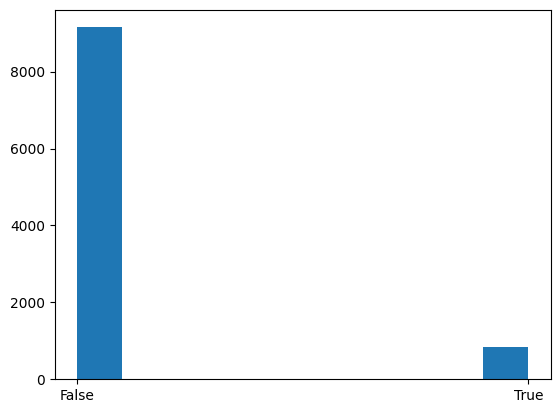

In [8]:
plt.hist(df['target'].astype(str))

#### Observation
- ##### The histogram plot shows the distribution of our good and bad reviews
##### We can see we have a lot of "happy" customers due to our target distribution

### Create your X with column reviews.text and Y with column target
### Split your dataset into train and test in the ratio 80:20

In [9]:
train_text, test_text, train_y, test_y = train_test_split(df['reviews.text'], df['target'], test_size=0.2)

In [10]:
train_text.shape

(8000,)

In [11]:
train_text.dtypes

dtype('O')

In [12]:
train_text

9649    Works really well on picking up spills on both...
7529    I use this product on the regular basis and Lo...
2907    As good as the first one, and the Windex coupo...
1191    Kept the grand kids occupied and glued to the ...
9433    I loove this poduct, don't know what I'd do wi...
                              ...                        
8444    little kids + fun mess these wipes are great f...
7571    these were great! I especially love the to go ...
4030    I have been doing this myself, cutting down fi...
9526    Easy to use fast and easy way to disinfect chi...
9771    Great product. I love the lemon smell and the ...
Name: reviews.text, Length: 8000, dtype: object

### Use a tokenizer from Keras to vectorize the text samples into a 2D integer tensor with 20000 words. Fit your tokenizer on train data (MAX_NB_WORDS = 20000)

In [13]:
MAX_NB_WORDS = 20000

# get the raw text data
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

# Vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)

### Convert train texts to sequences using the tokenizer texts_to_sequences method

In [14]:
sequences = tokenizer.texts_to_sequences(texts_train)

### Convert test texts to sequences using tokenizer texts_to_sequences method

In [15]:
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens")

Found 9279 unique tokens


In [16]:
sequences[0]

[115,
 51,
 58,
 26,
 1017,
 43,
 488,
 26,
 224,
 270,
 4,
 826,
 5,
 15,
 9,
 16,
 10,
 14,
 8,
 3,
 17]

##### The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted to reconstruct the original message (without formatting)

In [17]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 9279)

In [18]:
index_to_word = dict((i,w) for w, i in tokenizer.word_index.items())

In [19]:
" ".join([index_to_word[i] for i in sequences[0]])

'works really well on picking up spills on both carpet and tile this review was collected as part of a promotion'

##### The above code shows how to convert tokenized indices back to sentences
##### Let's have a closer look at the tokenized sequences:

In [20]:
seq_lens = [len(s) for s in sequences]
print(f"average length: {np.mean(seq_lens):.1f}")
print(f"max length: {max(seq_lens)}")

average length: 32.3
max length: 1036


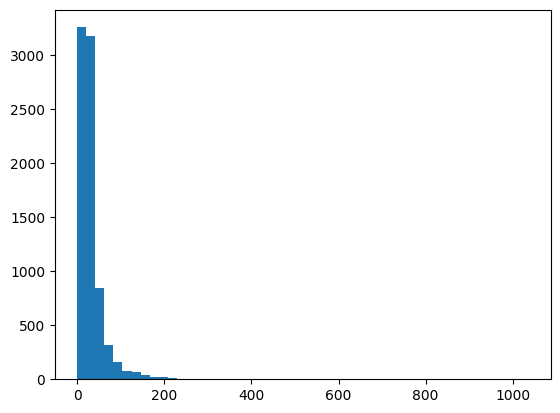

In [21]:
plt.hist(seq_lens, bins=50);

#### Observation
- ##### The histogram plot shows the number of words in reviews
##### Let's zoom on the distribution of regular sized posts. The vast majority of posts have less than 200 symbols:

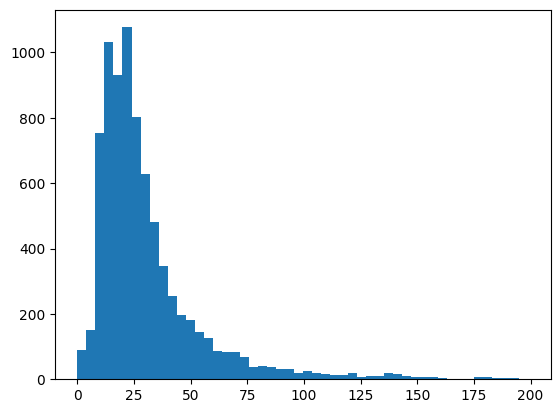

In [23]:
plt.hist([l for l in seq_lens if l < 200], bins=50);

#### Observation
- ##### The histogram plot shows that most of the reviews have words less than 200

### Pad train and test sequence (add 0s at the end until the sequence is of length 150). Consider MAX_SEQUENCE_LENGTH = 150 and this step gives x_train and x_test

In [24]:
MAX_SEQUENCE_LENGTH = 150

x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of test tensor:', x_test.shape)

Shape of data tensor: (8000, 150)
Shape of test tensor: (2001, 150)


### One-hot encode your output classes (True/False)

In [25]:
y_train = train_y
y_test = test_y

y_train = to_categorical(np.asarray(y_train))
print('Shape of train label tensor:', y_train.shape)
y_test = to_categorical(np.asarray(y_test))
print('Shape of test label tensor:', y_test.shape)

Shape of train label tensor: (8000, 2)
Shape of test label tensor: (2001, 2)


In [26]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

### Build a CNN - LSTM hybrid model with the following layers:
- ##### Input layer with input shape = MAX_SEQUENCE_LENGTH and dtype int32
- ##### Embedding layer with input dimension = MAX_NB_WORDS, output dimension =50, and input length = MAX_SEQUENCE_LENGTH
- ##### Conv1D layer with 64 filters and kernel size 5 and activation relu, followed by MaxPooling1D with pool size = 5
- ##### Dropout(0.2)
- ##### Conv1D layer with 64 filters and kernel size 5 and activation relu, followed by MaxPooling1D with pool size = 5
- ##### Dropout(0.2)
- ##### LSTM layer with 64 units
- ##### Dense layer with 2 neurons and activation softmax

In [32]:



EMBEDDING_DIM = 50
N_CLASSES = 2

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(64, 5)(embedded_sequences)
x = ReLU()(x)
# MaxPool divides the length of the sequence by 5

x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 5)(x)
x = ReLU()(x)
x = MaxPooling1D(5)(x)

# LSTM layer with a hidden size of 64
x = Dropout(0.2)(x)
x = LSTM(64)(x)


predictions = Dense(2, activation='softmax')(x)

model = Model(sequence_input, predictions)

##### We have built an embedding layer mapping each word to a vector representation
##### The goal here is to compute the vector representation of all words in each sequence and average them

### Compile the model with Adam optimizer and metric accuracy

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

### Train the model for 5 epochs and batch size 64

In [34]:
history = model.fit(x_train, y_train, validation_split=0.1, epochs=5, batch_size=64)

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - acc: 0.9066 - loss: 0.3452 - val_acc: 0.9112 - val_loss: 0.2870
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.9172 - loss: 0.2599 - val_acc: 0.9212 - val_loss: 0.2316
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.9382 - loss: 0.1854 - val_acc: 0.9237 - val_loss: 0.2283
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.9577 - loss: 0.1166 - val_acc: 0.9200 - val_loss: 0.2470
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.9746 - loss: 0.0838 - val_acc: 0.9100 - val_loss: 0.2811


### Evaluate the model on test text and print the test loss and accuracy

In [35]:
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

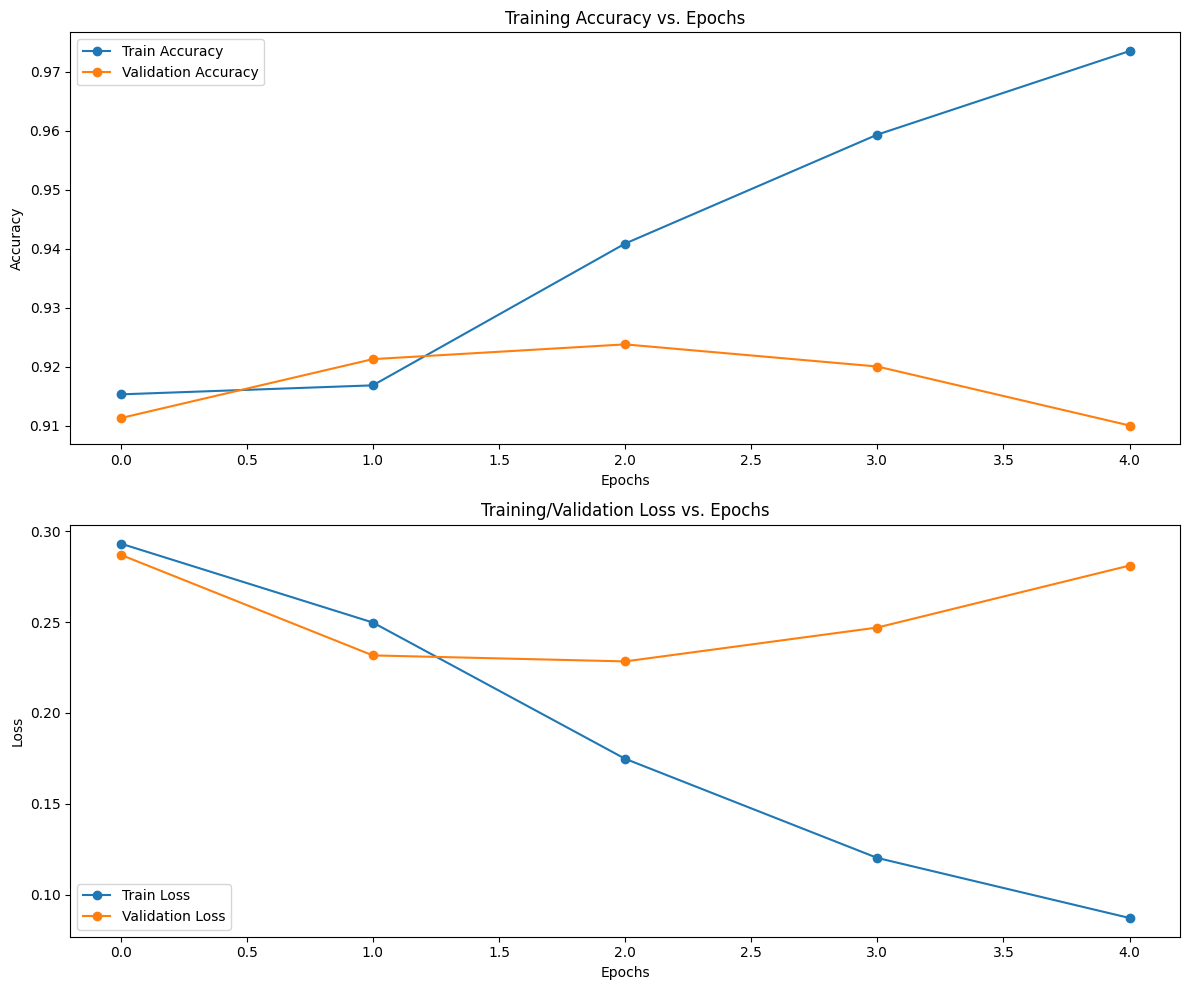

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

#### Observation
- ##### We see a constant decrease in the training loss where as validation loss starts increasing after some point
- ##### The plot shows that the model starts to overfit and we have a variance problem here
- ##### Adding regularization like drop-out and other techniques may help to stabilize the performance

In [37]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test, output_test))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
test auc: 0.8027345973362341


In [38]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9144 - loss: 0.2897
Test Loss:     0.30026775598526
Test Accuracy: 0.9115442037582397


#### Observation
- ##### The model has given a decent accuracy of 91.75% on unseen test dataset
- ##### The AUC score on test dataset is 80%


#### Conclusion
- ##### Deep Learning can be better on text classification than simpler ML techniques, but only on very large datasets and well designed/tuned models.
- ##### A CNN-LSTM hybrid networks gives a solution to use both structural characterization and spatial information together.
- ##### The following projects can replicate similar word embedding models much more efficiently: word2vec and gensim's word2vec (self-supervised learning only), fastText (both supervised and self-supervised learning), Vowpal Wabbit (supervised learning).
